In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from tqdm import tqdm
import math

import sys
sys.path.append('/repo')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Preparacion de Data

In [2]:

# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the grayscale image
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the grayscale image
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(root='./data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='./data/test', transform=val_transforms)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)

# Check if the DataLoader works as expected
for images, labels in train_loader:
    print(images.size(), labels.size())
    break


torch.Size([128, 1, 48, 48]) torch.Size([128])


## Entrenamiento de modelos

In [3]:
import copy

# Training function with CUDA checks
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'weights': [],
    }
    nanEcnounter = False
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        if nanEcnounter:
            break
        
        # Initialize tqdm progress bar for the training loop
        train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for i, (inputs, labels) in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if math.isnan(running_loss):
                nanEcnounter = True
                break
            
            # Update tqdm progress bar
            train_bar.set_postfix({
                'train_loss': running_loss / ((i + 1) * train_loader.batch_size),
                'train_acc': correct / total
            })

        train_bar.clear()
        train_bar.close()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        # Initialize variables for storing predictions and labels
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)

                # Store predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate loss and accuracy
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total

        # Calculate precision, recall, and F1 score
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Append metrics to history
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)
        history['weights'].append(copy.deepcopy(model.state_dict()))

    return history


In [8]:
import copy
import torch
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# Training function with CUDA checks
def train_with_sch_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=10):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'weights': [],
    }
    
    nanEncounter = False
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        if nanEncounter:
            print("NaN encountered. Stopping training.")
            break
        
        # Initialize tqdm progress bar for the training loop
        train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for i, (inputs, labels) in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Check for NaN in the loss
            if torch.isnan(loss).any():
                nanEncounter = True
                break
            
            # Update tqdm progress bar
            train_bar.set_postfix({
                'train_loss': running_loss / ((i + 1) * train_loader.batch_size),
                'train_acc': correct / total
            })

        train_bar.clear()
        train_bar.close()

        # Calculate epoch training loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        # Initialize variables for storing predictions and labels
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)

                # Store predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate loss and accuracy
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total

        # Calculate precision, recall, and F1 score
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # Append metrics to history
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)

        # Save the model weights if validation accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Step the scheduler
        scheduler.step(val_loss)

    history['weights'] = best_model_wts
    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return history


In [5]:
def plot_results(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    precision = history.get('val_precision', [])
    recall = history.get('val_recall', [])
    f1 = history.get('val_f1', [])
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(24, 12))
    
    # Plotting Training and Validation Accuracy with markers
    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    # Plotting Training and Validation Loss with markers
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Plotting Validation Precision, Recall, and F1 Score
    if precision and recall and f1:  # Only plot if these metrics are available
        plt.subplot(2, 2, 3)
        plt.plot(epochs, precision, 'go-', label='Validation Precision')  # 'go-' means green color, circle marker, solid line
        plt.plot(epochs, recall, 'mo-', label='Validation Recall')  # 'mo-' means magenta color, circle marker, solid line
        plt.plot(epochs, f1, 'co-', label='Validation F1 Score')  # 'co-' means cyan color, circle marker, solid line
        plt.grid(True)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Metrics')
    
    plt.tight_layout()
    plt.show()

def get_best_epoch(history):
    val_acc = history['val_acc']
    val_f1 = history.get('val_f1', [])

    if val_f1:  # If F1 scores are available, use them to determine the best epoch
        best_epoch = val_f1.index(max(val_f1)) + 1
        best_f1 = max(val_f1)
        print(f'Best Validation F1 Score {best_f1}, is for epoch {best_epoch}')
    else:  # Otherwise, fall back to accuracy
        best_epoch = val_acc.index(max(val_acc)) + 1
        best_acc = max(val_acc)
        print(f'Best Validation Accuracy Score {best_acc}, is for epoch {best_epoch}')
    
    return best_epoch

# Function to get true and predicted labels from the model and DataLoader
def get_true_and_pred_labels(model, dataloader, device):
    model.eval()
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    return np.array(true_labels), np.array(pred_labels)

# Function to plot confusion matrix
def plot_confusion_matrix(model, dataloader, class_names, device):
    y_true, y_pred = get_true_and_pred_labels(model, dataloader, device)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
    plt.show()


In [ ]:
def plot_per_class_accuracy(model, dataloader, class_names, device):
    y_true, y_pred = get_true_and_pred_labels(model, dataloader, device)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate per-class accuracy: correct predictions / total samples for each class
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    # Plot per-class accuracy
    plt.figure(figsize=(12, 8))
    plt.barh(class_names, per_class_accuracy, color='skyblue')
    plt.xlabel('Accuracy')
    plt.title('Per-Class Accuracy')
    
    # Show accuracy values on the bars
    for i, v in enumerate(per_class_accuracy):
        plt.text(v + 0.01, i, f"{v:.2f}", color='blue', va='center')
    
    plt.xlim([0, 1])  # Accuracy is a value between 0 and 1
    plt.grid(True, axis='x')
    plt.show()


### Red Convolucional

Using device: cuda

--- testing model: CNN ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.1
----------------------------------


Best Validation F1 Score 0.6156897021817868, is for epoch 48


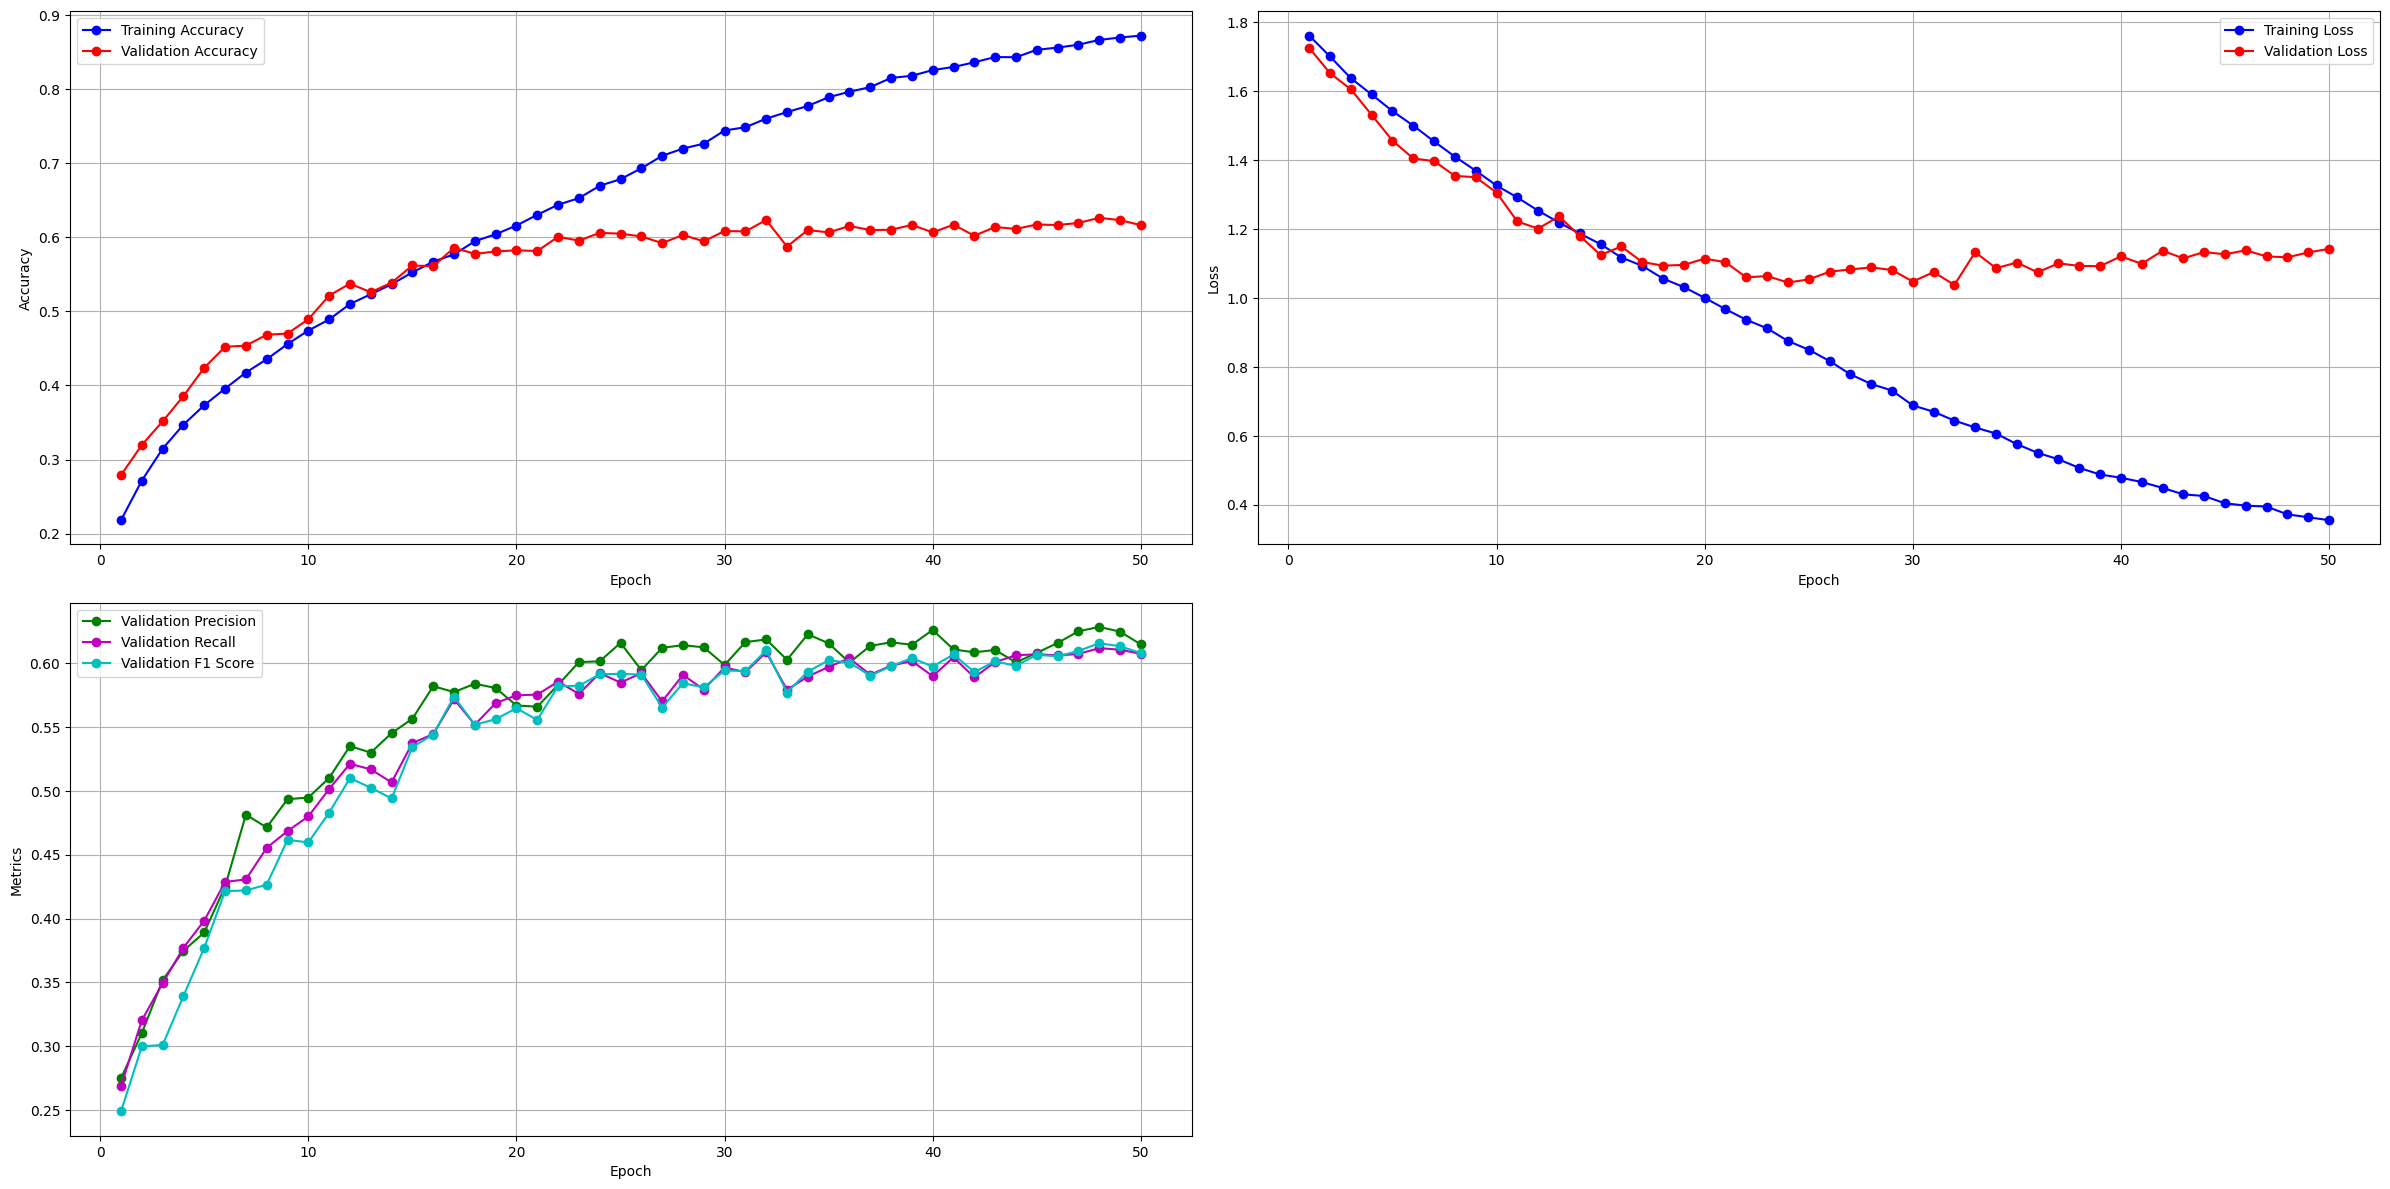

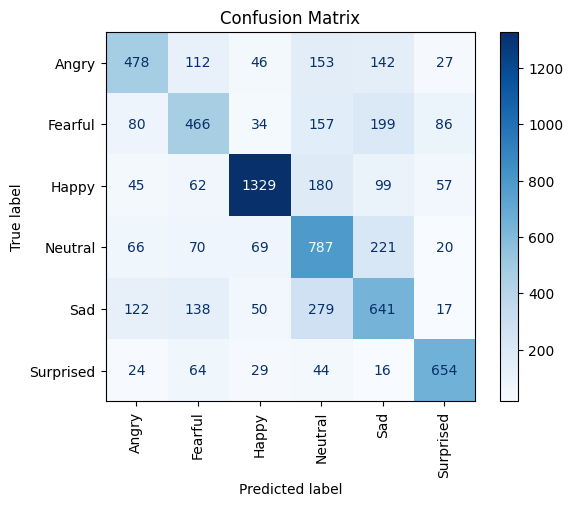


--- testing model: CNN ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
----------------------------------


Best Validation F1 Score 0.4322772069419962, is for epoch 47


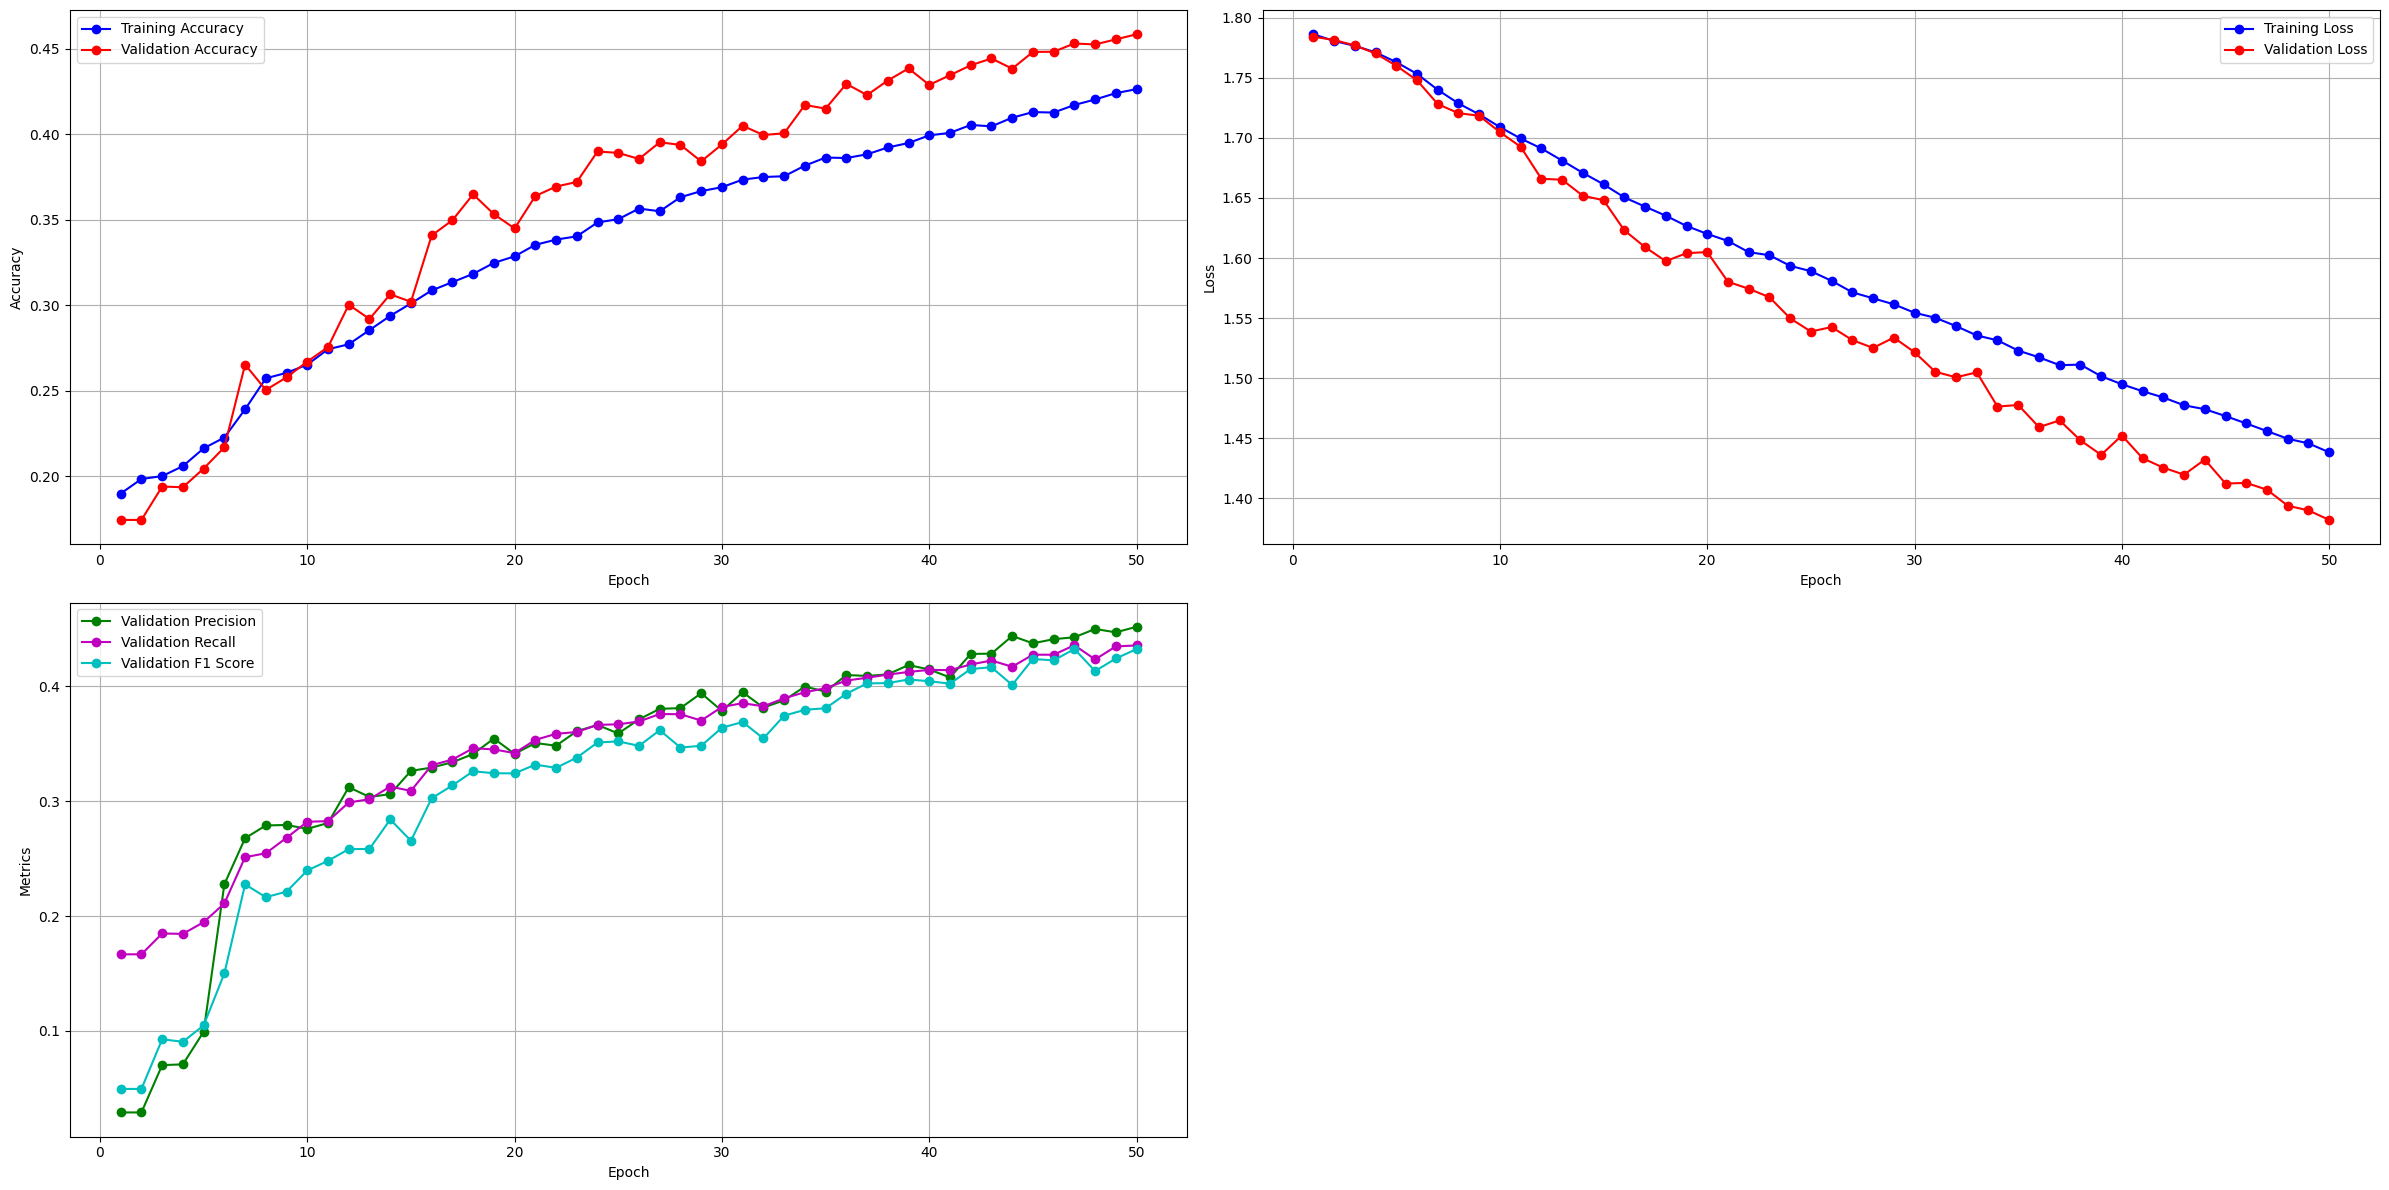

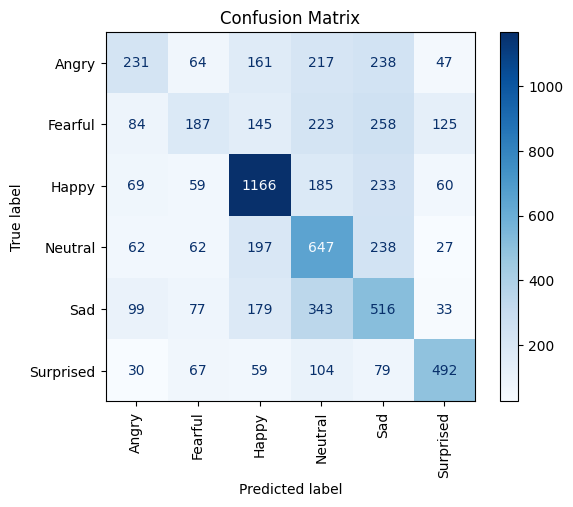

In [12]:
from src.models import ConvNet
import copy

models = [ConvNet()]
model_labels = ['CNN']
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizers = [optim.SGD]
optimizer_labels = ['SGD']

lrs = [0.1, 0.01]

trials_CNN = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
class_names = ["Angry", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]

for model_index, model in enumerate(models):
    model.to(device)
    initial_state = copy.deepcopy(model.state_dict())

    for optimizer_index, optimizer in enumerate(optimizers):

        for criterion_index, criterion in enumerate(criterions):
            for lr in lrs:
                print(f'\n--- testing model: {model_labels[model_index]} ---')
                print(f'optimizer: {optimizer_labels[optimizer_index]}')
                print(f'criterion: {criterion_labels[criterion_index]}')
                print(f'lr: {lr}')
                print('----------------------------------')

                model.load_state_dict(initial_state)
                actual_optimizer = optimizer(model.parameters(), lr=lr)
                history = train_model(model, criterion, actual_optimizer, train_loader, val_loader, epochs=50)

                best_epoch = get_best_epoch(history)
                plot_results(history)
                plot_confusion_matrix(model, val_loader, class_names, device)

                
                trials_CNN.append({
                    'model': model_labels[model_index],
                    'optimizer': optimizer_labels[optimizer_index],
                    'criterion': criterion_labels[criterion_index],
                    'lr': lr,
                    'history': history,
                    'best_epoch': best_epoch,
                    'history': history['weights'],
                })

                best = history['weights'][best_epoch - 1]
                name = './exports/' + model_labels[model_index] + '_' + str(lr).replace('.', '') + '.pt'
                torch.save(best, name)




In [12]:
import gc
torch.cuda.empty_cache()
gc.collect()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
Allocated: 0.5 GB
Cached:    0.7 GB


### Resnet

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Using device: cuda

--- testing model: Resnet ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.1
----------------------------------


Best Validation F1 Score 0.5050775868535916, is for epoch 13


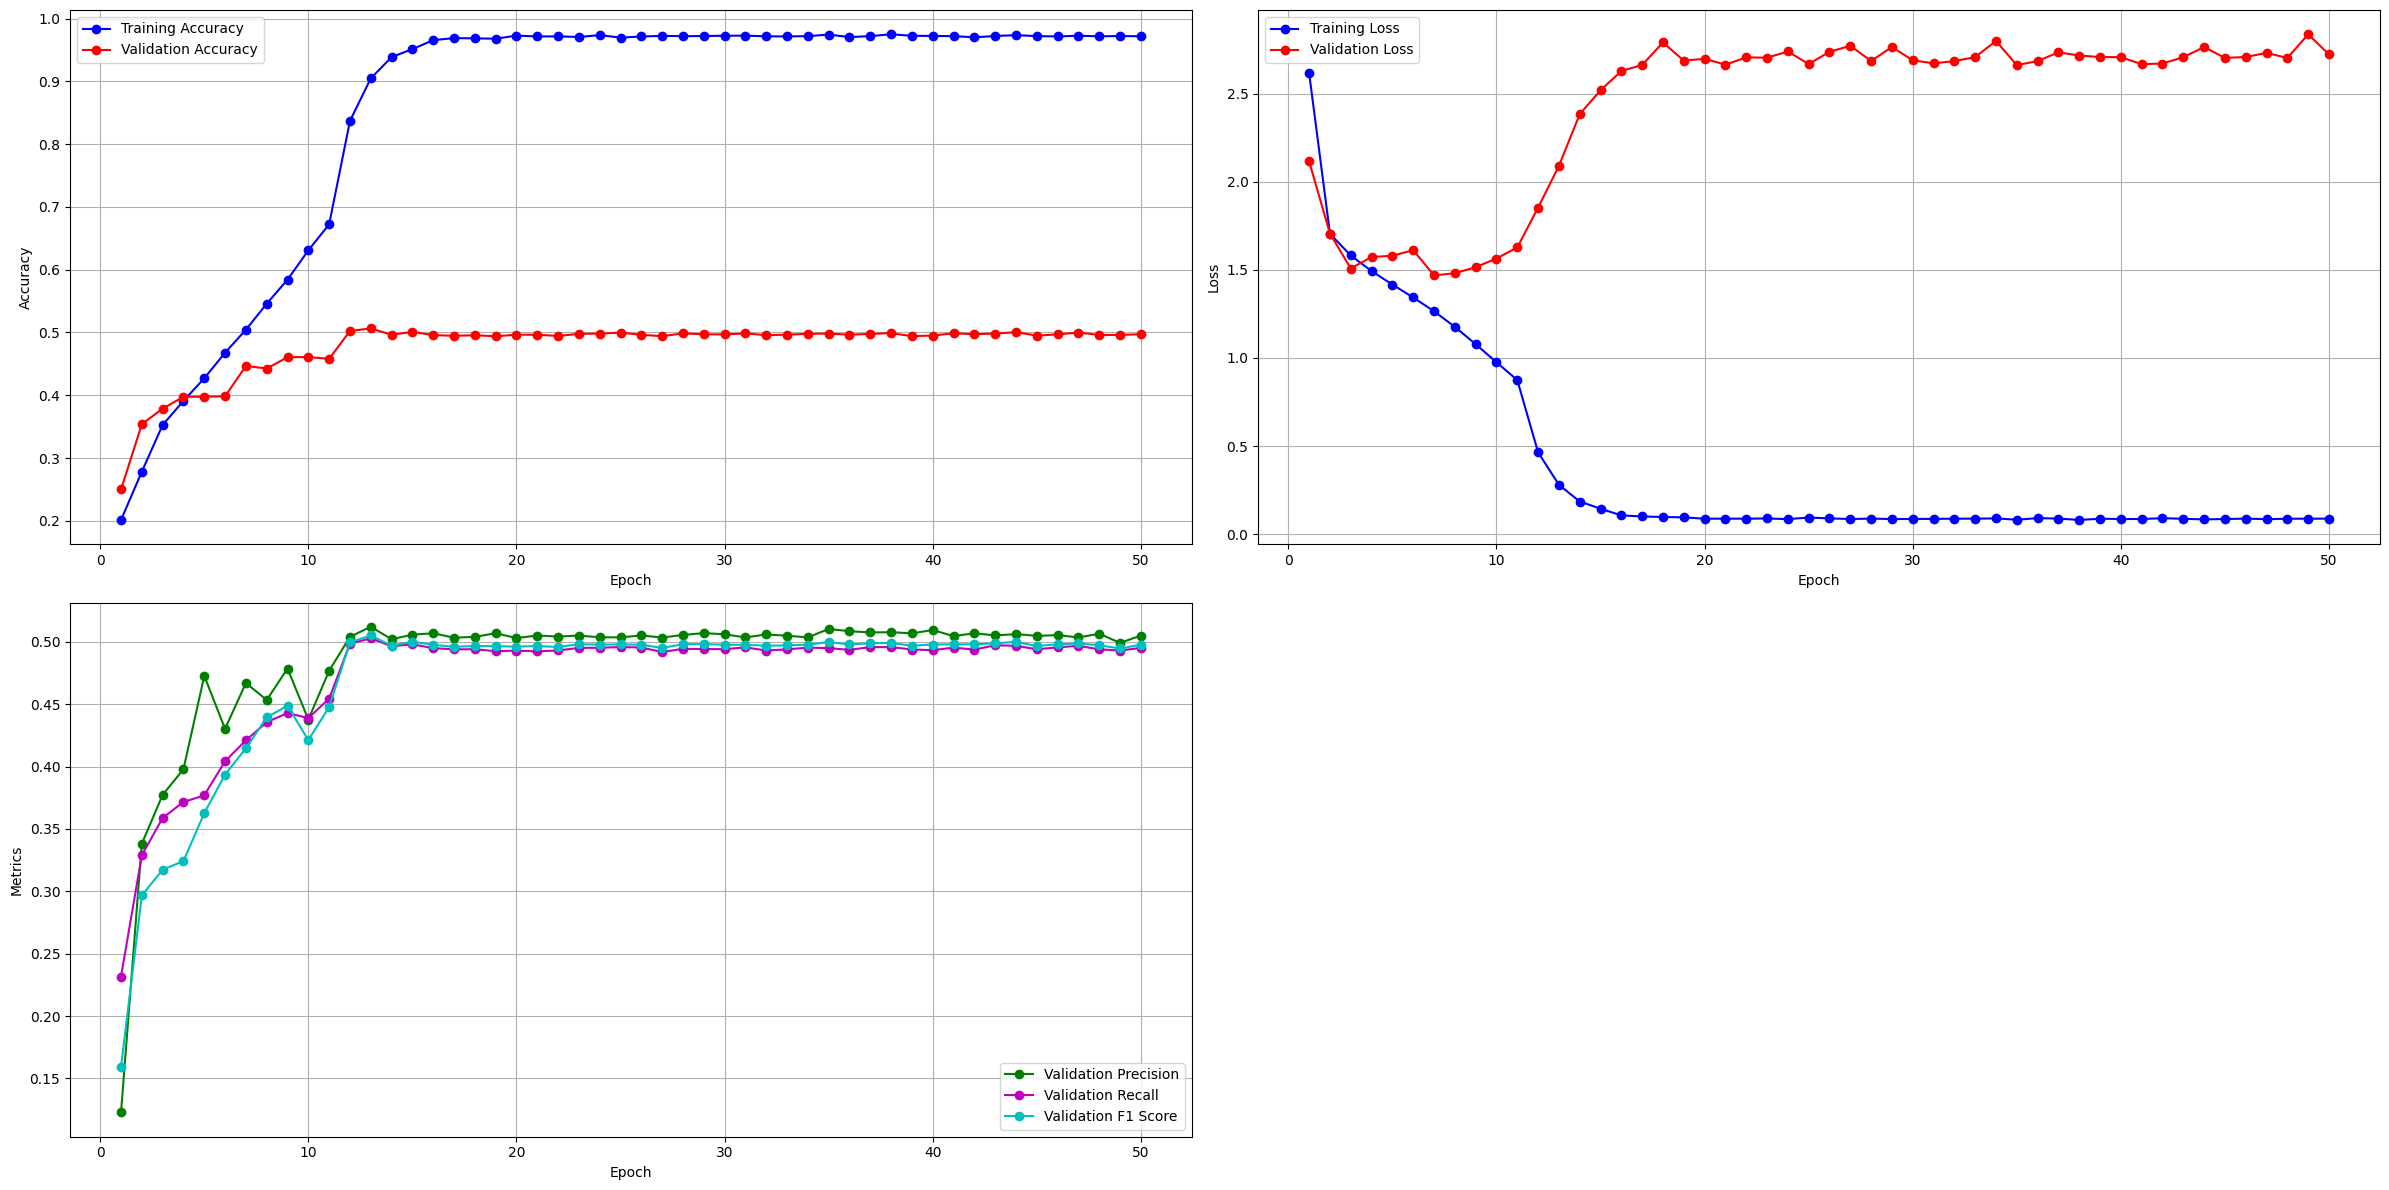

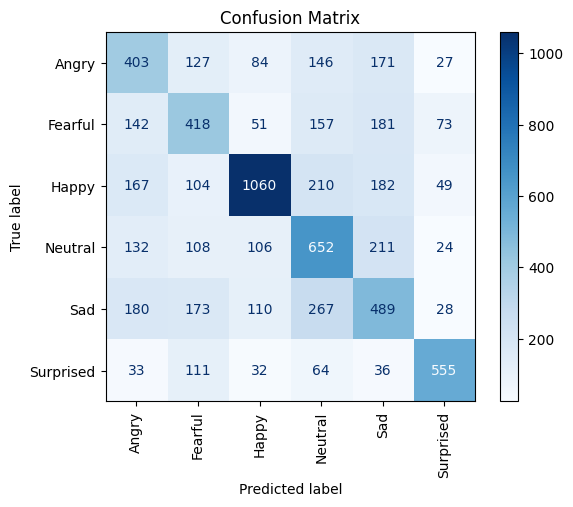


--- testing model: Resnet ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
----------------------------------


Best Validation F1 Score 0.45617731611172885, is for epoch 22


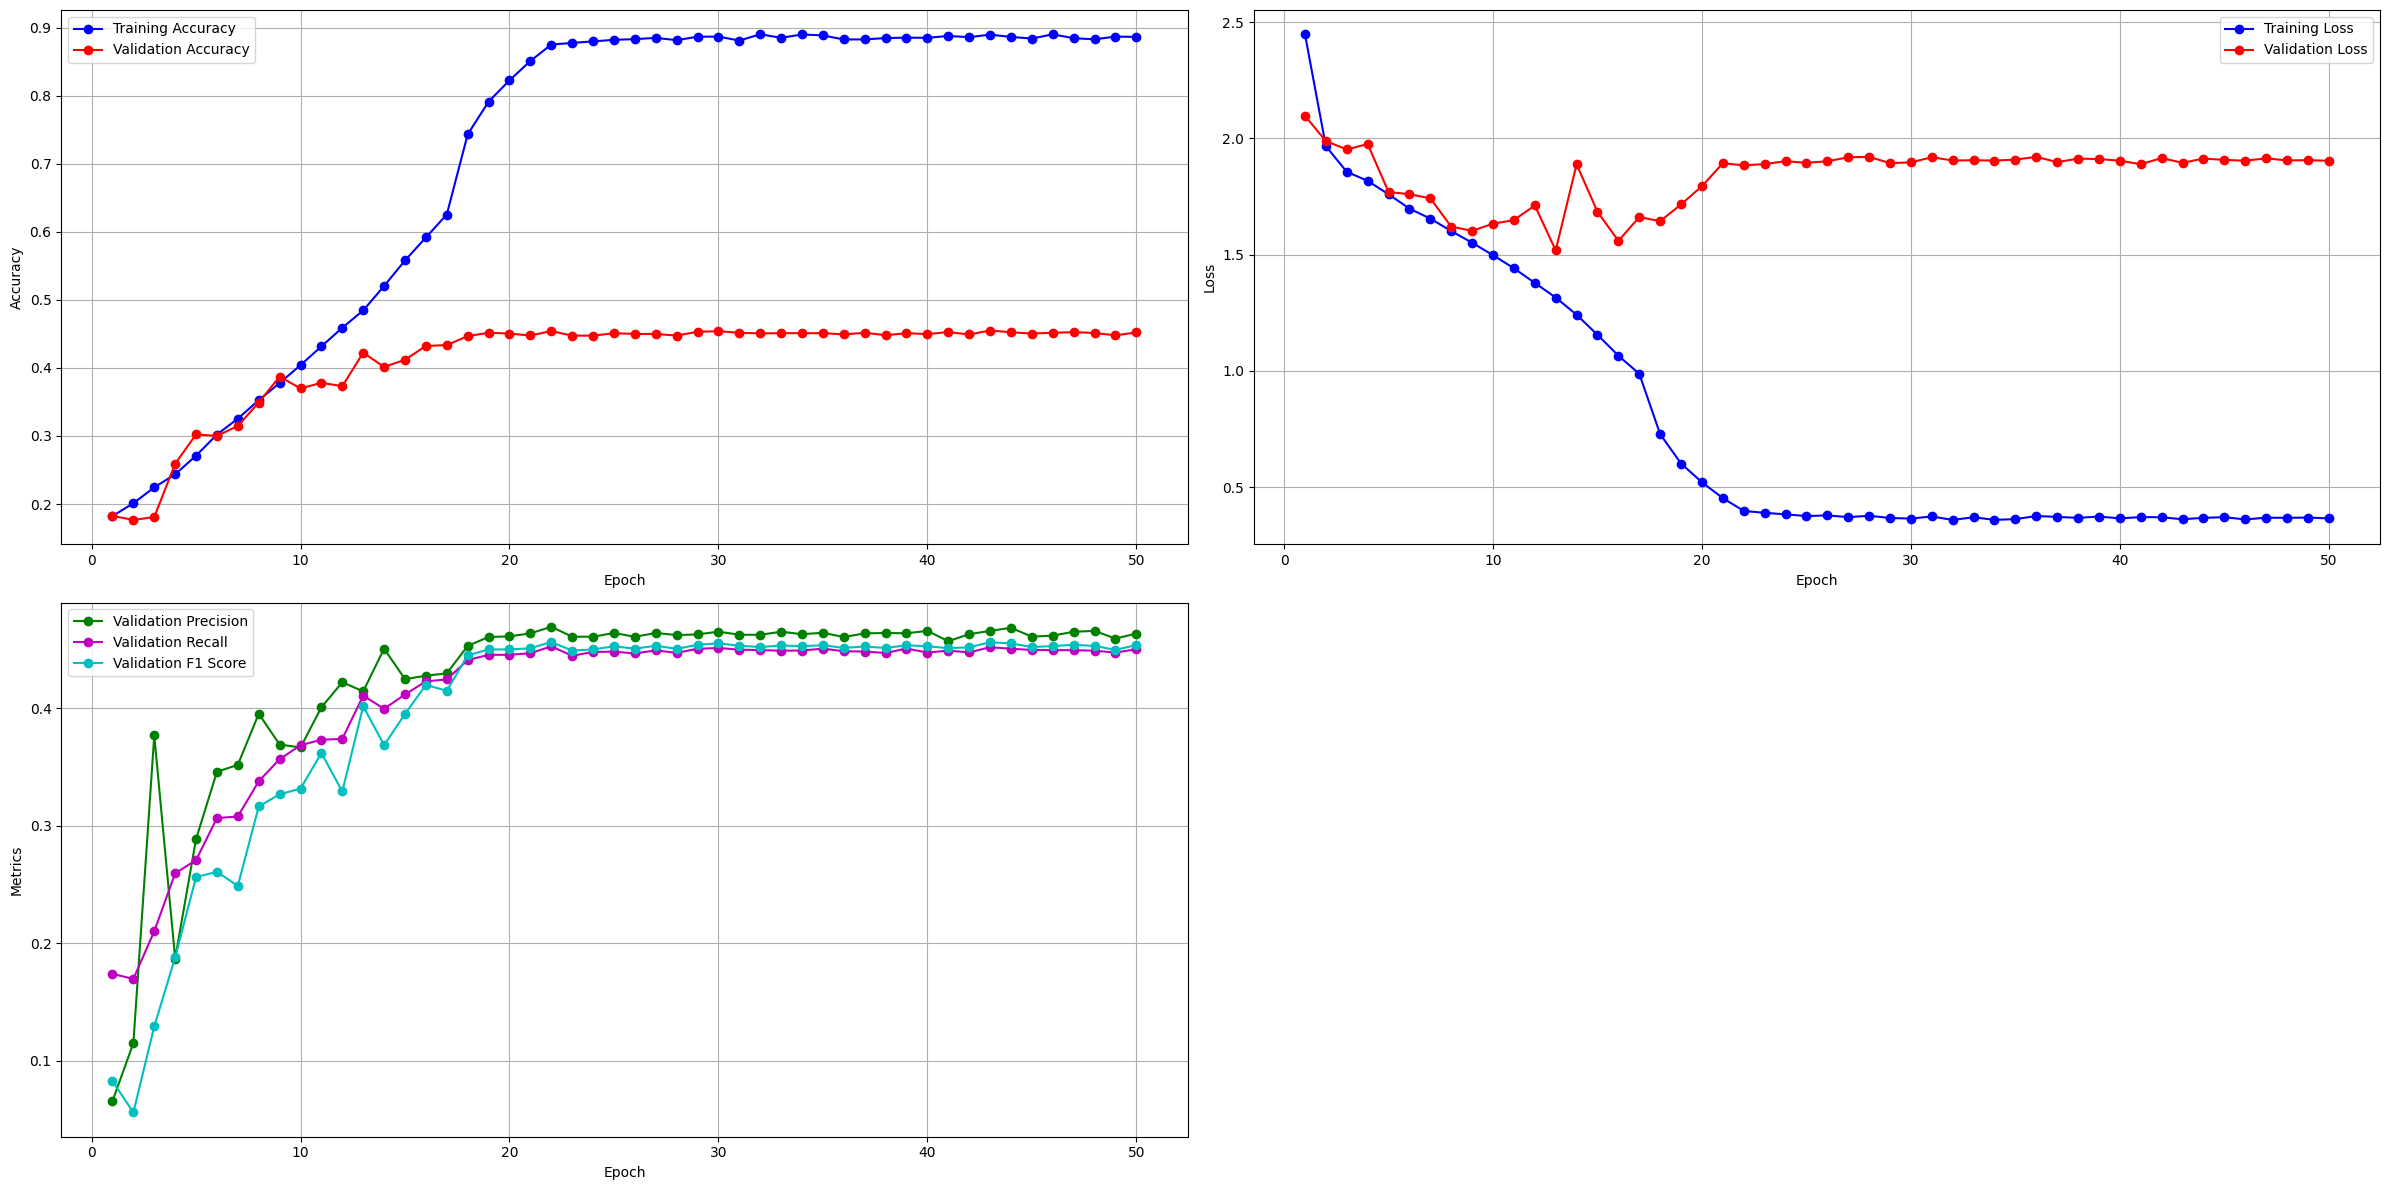

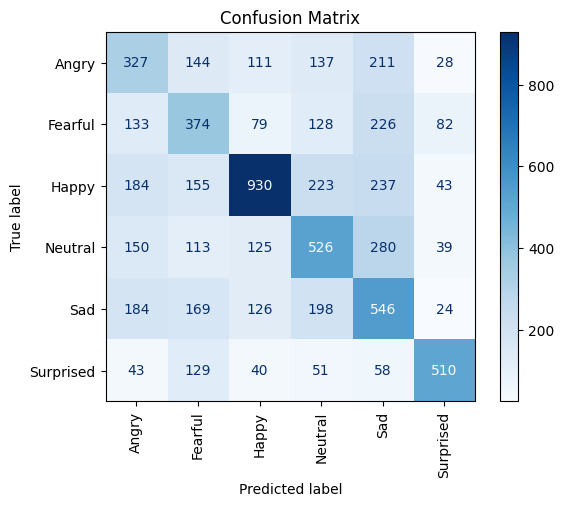

In [13]:
import copy

resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)

resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 6)

models = [resnet]
model_labels = ['Resnet']
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizers = [optim.SGD]
optimizer_labels = ['SGD']

lrs = [0.1, 0.01]

trials_resnet = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
class_names = ["Angry", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]

for model_index, model in enumerate(models):
    model.to(device)
    initial_state = copy.deepcopy(model.state_dict())

    for optimizer_index, optimizer in enumerate(optimizers):

        for criterion_index, criterion in enumerate(criterions):
            for lr in lrs:
                print(f'\n--- testing model: {model_labels[model_index]} ---')
                print(f'optimizer: {optimizer_labels[optimizer_index]}')
                print(f'criterion: {criterion_labels[criterion_index]}')
                print(f'lr: {lr}')
                print('----------------------------------')

                model.load_state_dict(initial_state)
                actual_optimizer = optimizer(model.parameters(), lr=lr, momentum=0.2)
                # scheduler = torch.optim.lr_scheduler.ExponentialLR(actual_optimizer, gamma=0.9)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(actual_optimizer, mode='min', factor=0.1, patience=3)

                # After each epoch during training, call this with validation loss
                history = train_with_sch_model(model, criterion, actual_optimizer, scheduler, train_loader, val_loader, epochs=50)

                best_epoch = get_best_epoch(history)
                plot_results(history)
                plot_confusion_matrix(model, val_loader, class_names, device)

                trials_resnet.append({
                    'model': model_labels[model_index],
                    'optimizer': optimizer_labels[optimizer_index],
                    'criterion': criterion_labels[criterion_index],
                    'lr': lr,
                    'history': history,
                    'best_epoch': best_epoch,
                    'history': history['weights'],
                })

                best = history['weights']
                name = './exports/' + model_labels[model_index] + '_' + str(lr).replace('.', '') + '.pt'
                torch.save(best, name)
 

In [16]:
import gc
torch.cuda.empty_cache()
gc.collect()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 4070 Laptop GPU
Memory Usage:
Allocated: 0.9 GB
Cached:    1.1 GB


### VGG

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Using device: cuda

--- testing model: VGG-11 ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.1
----------------------------------


Best Validation F1 Score 0.5861275349836302, is for epoch 14


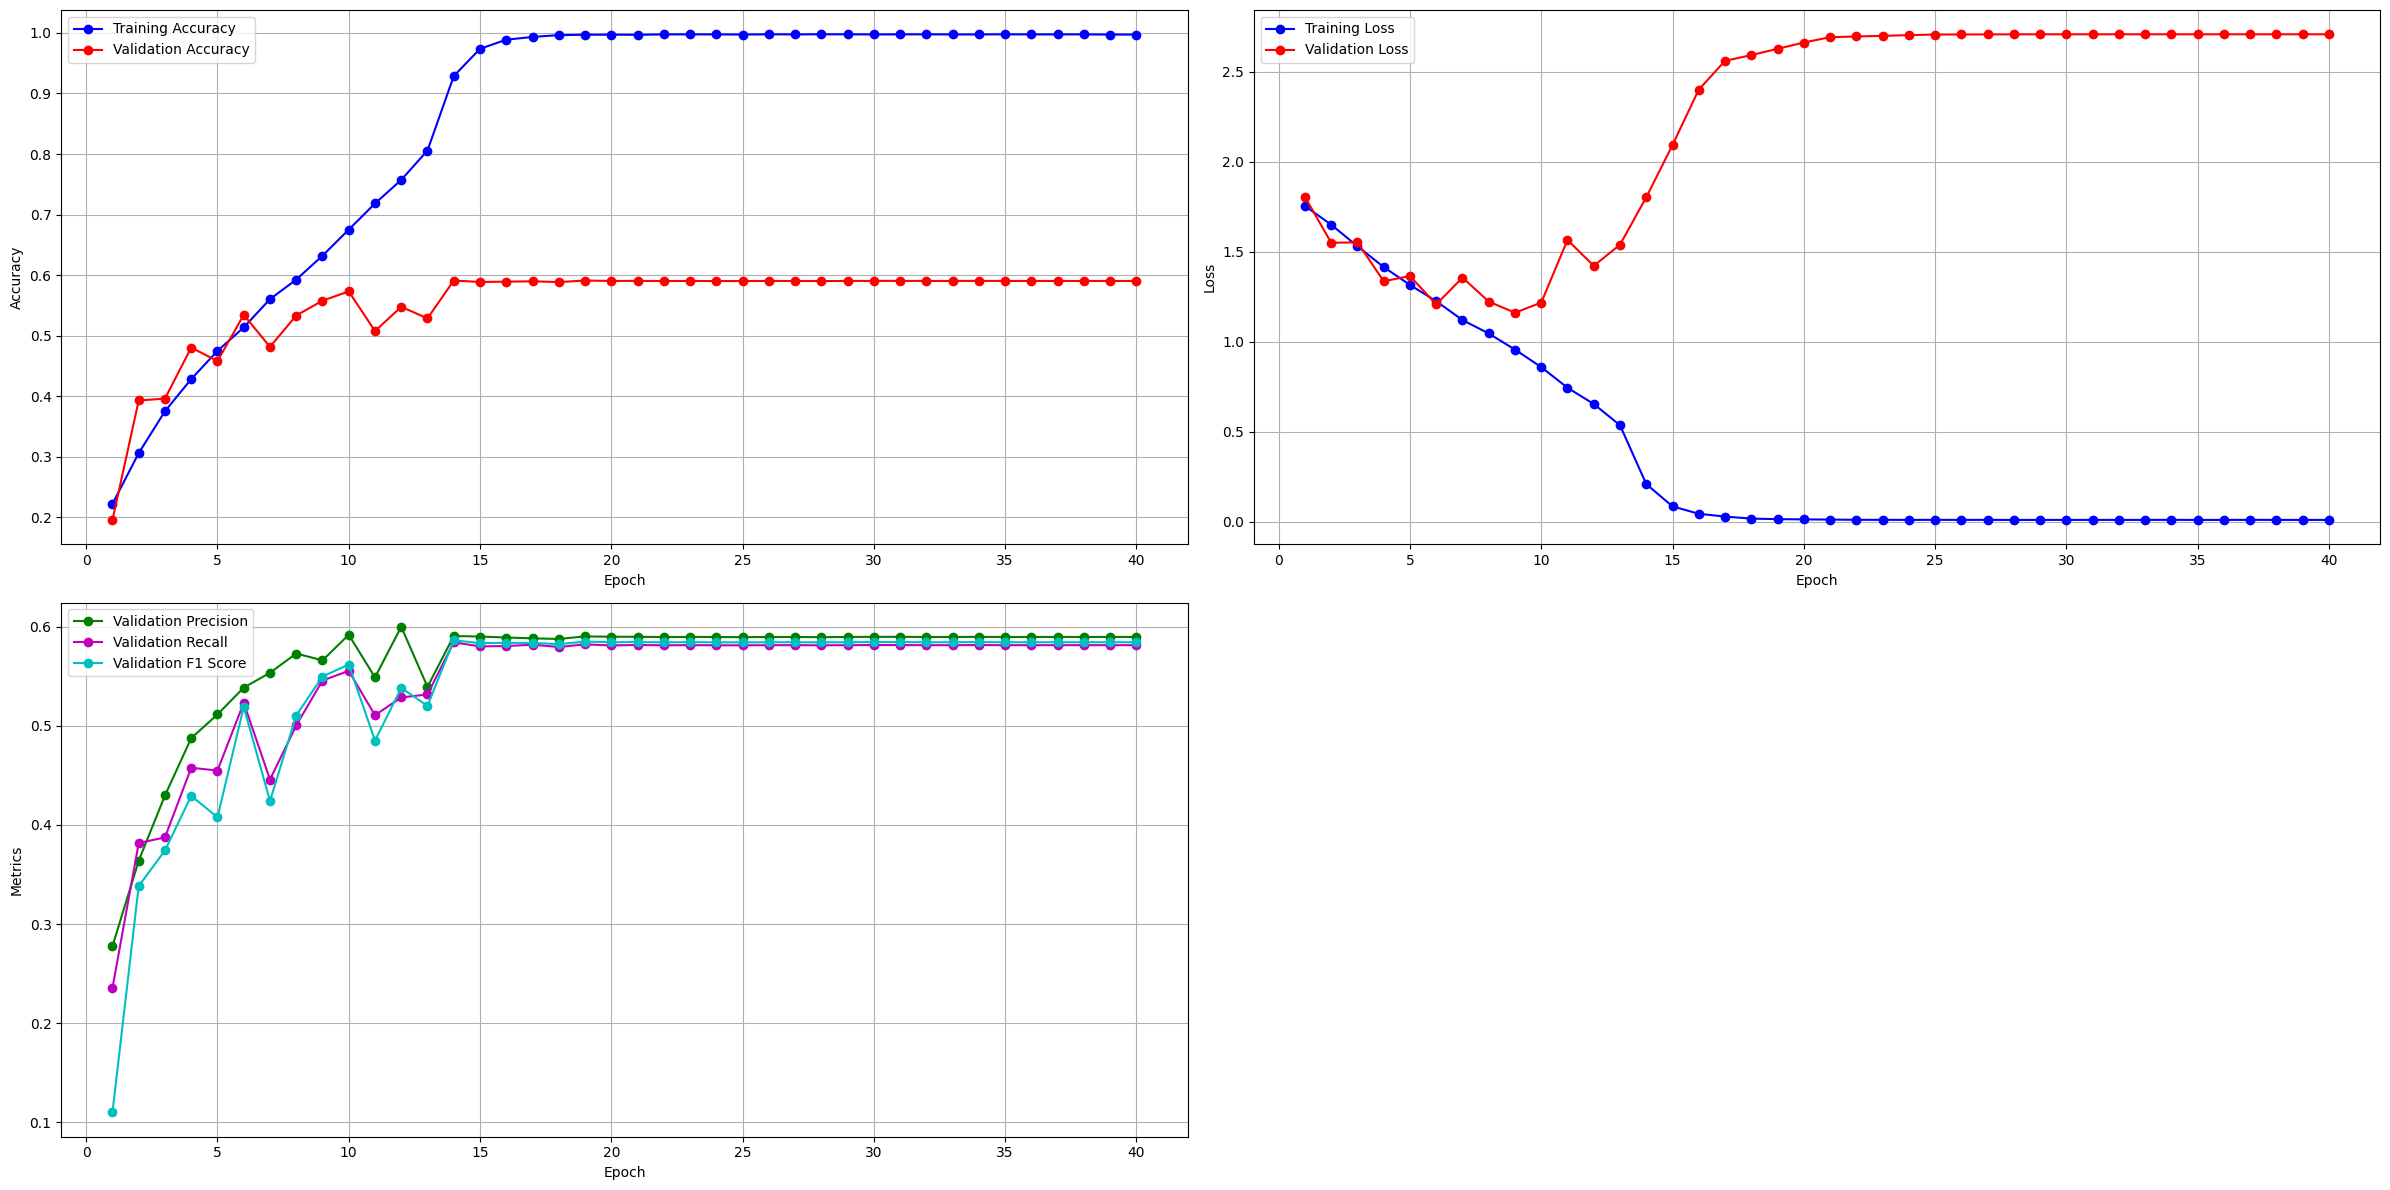

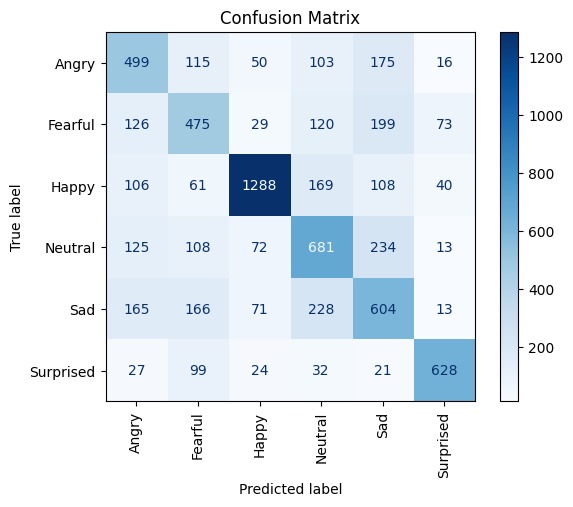


--- testing model: VGG-11 ---
optimizer: SGD
criterion: Cross Entropy Loss
lr: 0.01
----------------------------------


Best Validation F1 Score 0.5457810555126286, is for epoch 19


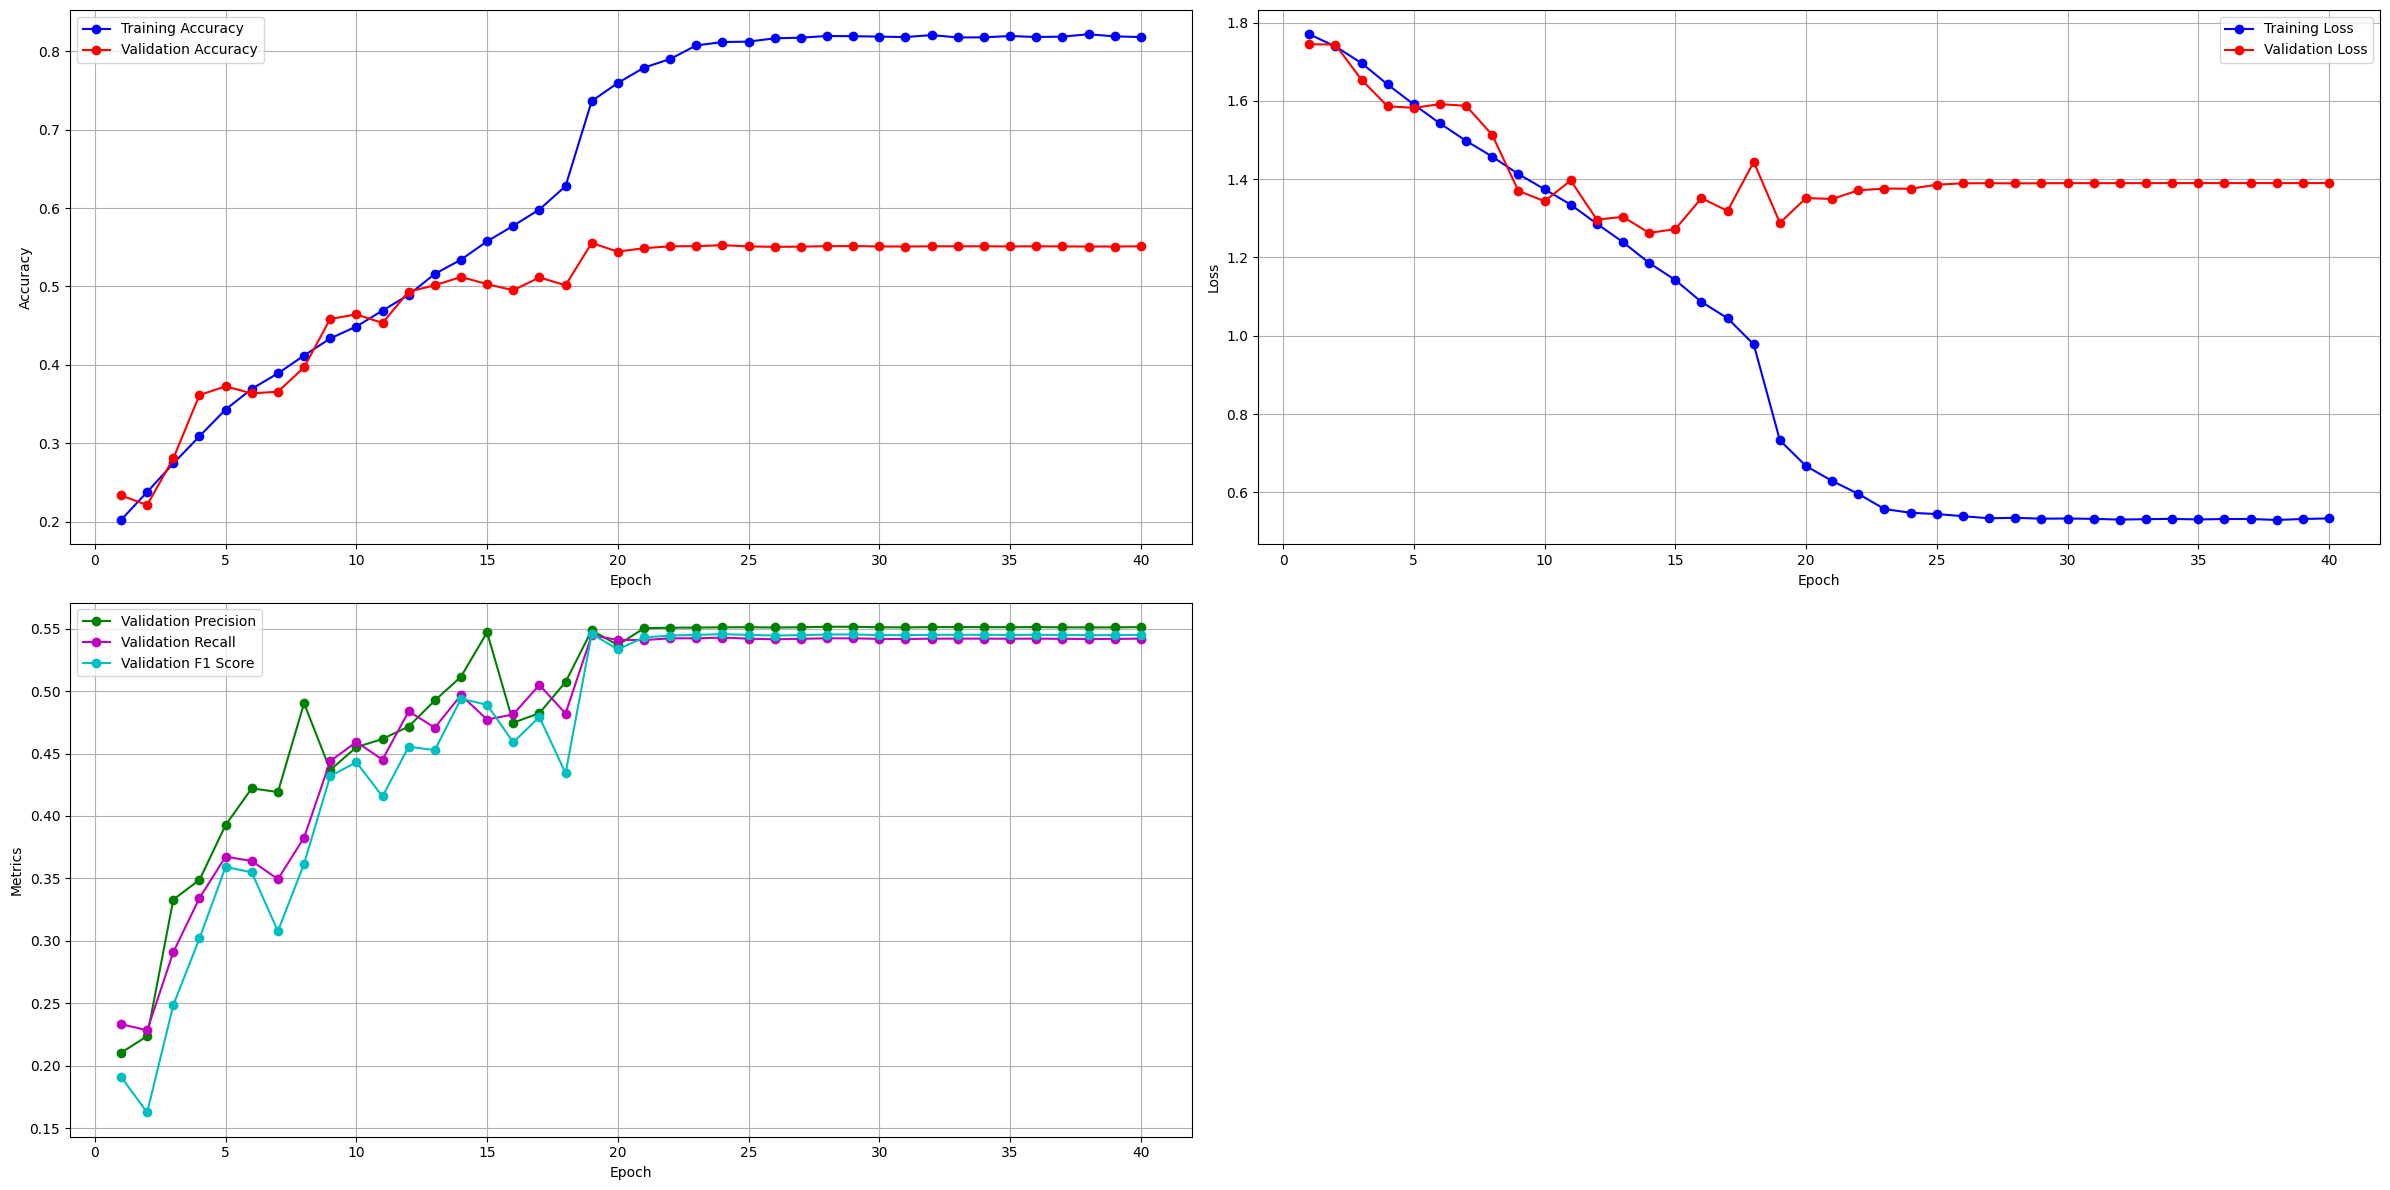

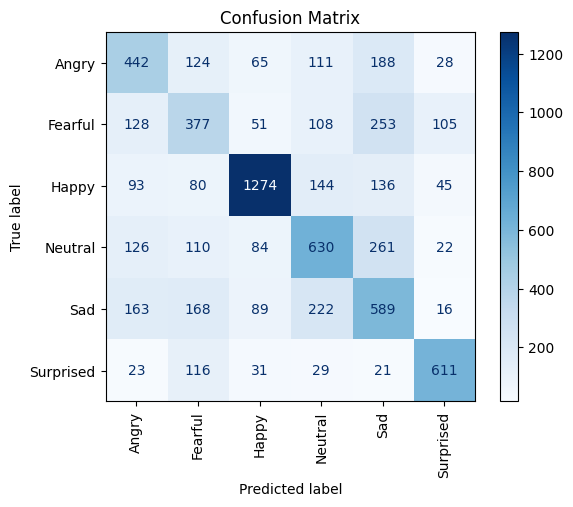

In [17]:
import copy

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', weights=None)

# Modify the first convolutional layer to accept grayscale images
# Original: nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# Modify the classifier to output 6 classes instead of 1000
# The original VGG has:
# model.classifier[-1] = nn.Linear(4096, 1000)
model.classifier[-1] = nn.Linear(4096, 6)
models = [model]
model_labels = ['VGG-11']
criterions = [
    nn.CrossEntropyLoss(),
]
criterion_labels = ['Cross Entropy Loss']

optimizers = [optim.SGD]
optimizer_labels = ['SGD']

lrs = [0.1, 0.01]

trials_vgg = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
class_names = ["Angry", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]

for model_index, model in enumerate(models):
    model.to(device)
    initial_state = copy.deepcopy(model.state_dict())

    for optimizer_index, optimizer in enumerate(optimizers):

        for criterion_index, criterion in enumerate(criterions):
            for lr in lrs:
                print(f'\n--- testing model: {model_labels[model_index]} ---')
                print(f'optimizer: {optimizer_labels[optimizer_index]}')
                print(f'criterion: {criterion_labels[criterion_index]}')
                print(f'lr: {lr}')
                print('----------------------------------')

                model.load_state_dict(initial_state)
                actual_optimizer = optimizer(model.parameters(), lr=lr, momentum=0.2)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(actual_optimizer, mode='min', factor=0.1, patience=3)

                # After each epoch during training, call this with validation loss
                history = train_model(model, criterion, actual_optimizer, scheduler, train_loader, val_loader, epochs=40)

                best_epoch = get_best_epoch(history)
                plot_results(history)
                plot_confusion_matrix(model, val_loader, class_names, device)

                trials_vgg.append({
                    'model': model_labels[model_index],
                    'optimizer': optimizer_labels[optimizer_index],
                    'criterion': criterion_labels[criterion_index],
                    'lr': lr,
                    'history': history,
                    'best_epoch': best_epoch,
                    'history': history['weights'],
                })

                torch.save(model.state_dict(), f'./exports/{model_labels[model_index]}_{lr}')

                best = history['weights']
                name = './exports/' + model_labels[model_index] + '_' + str(lr).replace('.', '') + '.pt'
                torch.save(best, name)
